In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/linear/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/02_train_linear.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['r2_test'] = r['r2_test'].clip(-1, 1)
r['r2_gap'] = r['r2_train'] - r['r2_test']
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_bagging_ensemble == 1], actually_delete=True)
# imodelsx.process_results.get_experiment_keys(r, experiment_filename)

## Look at pred performance

In [ ]:
d = r
for k in ["seed"]: #, "dataset_name"]:
    d = imodelsx.process_results.average_over_seeds(
        d, experiment_filename, key_to_average_over=k
    )

d["legend"] = (
    "Marg: "
    + d["est_marginal_name"]
    + d["use_marginal_divide_by_d"].map({0: "(no div) ", 1: ""})
    + ", "
    + "Main: "
    + d["est_main_name"]
    + d['use_marginal_sign_constraint'].map({0: "", 1: " (sign-constr)"})
)

# d = d[d.legend.str.contains('Main: ridge', case=False)]
d = d[~(d.legend == 'Marg: ridge, Main: None')]

fig, ax = plt.subplots(figsize=(10, 5))
# x = 'collinearity_factor' # 'train_frac', 'y_train_noise_std', 'collinearity_factor'
# x = 'train_frac'
x = "alpha"
# sns.lineplot(data=r, x="train_frac", y="r2_test", hue="legend", markers=True)
sns.lineplot(
    data=d, x=x, y="r2_test", hue="legend", markers=True, marker="o", alpha=0.5
)
plt.xscale("log")
plt.grid()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.yscale("log")
plt.show()

In [ ]:
d2 = d
# d2 = d2[r.train_frac >= 0.8]
# d2 = d2[d.r2_test >= 0.3]
d2 = d2[~(d2.legend == 'Marg: ridge, Main: None')]
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=d2, x="train_frac", y="r2_test", hue="legend", errorbar='se')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# d = r[r.train_frac >= 0.8]
# d = r[r.train_frac <= 0.3]
# d = d[d.r2_test >= 0.3]
# d2 = d[d.legend.str.contains('lasso', case=False)]
# fig, ax = plt.subplots(figsize=(10, 10)) #figsize=(10, 5))
fig, ax = plt.subplots(figsize=(5, 5)) #figsize=(10, 5))
sns.barplot(data=d2, y= "dataset_name", x="r2_test", hue="legend")
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='xx-small')
# place legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fontsize='xx-small',)
# set yticks fontsize small
plt.yticks(fontsize='xx-small')
plt.tight_layout()
plt.show()

# Analyze coefs

In [101]:
d = r
# d = d[d.seed == 1]
# d = d[d.use_marginal_divide_by_d == 1]
# d = d[d.collinearity_factor == 0.0]

df = defaultdict(list)
# models = ["lasso"]
models = ["ridge", "lasso", "elasticnet"]
for model in models:
    df_model = defaultdict(list)
    for idx, g in d.groupby(
        [
            "dataset_name",
            # "est_marginal_name",
            "seed",
        ]
    ):
        row_marg = g[(g.est_marginal_name == "ridge") & (g.est_main_name == "None")]
        row_baseline = g[(g.est_marginal_name == "None") & (g.est_main_name == model)]
        coef_baseline = row_baseline.coef.values[0]
        row_shrinkage = g[(g.est_marginal_name == "ridge") & (g.est_main_name == model)]

        df_model["dataset_name"].append(idx[0])

        def sign_match(x, y):
            return np.mean(
                (np.sign(x) == np.sign(y)) | (np.sign(x) == 0) | (np.sign(y) == 0)
            )

        df_model["sign_flip_frac_baseline"].append(
            1 - sign_match(row_marg.coef.values[0], coef_baseline)
        )
        # df_model["sign_agreement_shrinkage"].append(sign_match(coef_marg, coef_shrinkage))
        df_model["flipped_values_baseline"].append(
            coef_baseline[np.sign(row_marg.coef.values[0]) != np.sign(coef_baseline)]
        )
        df_model["sum_abs_flipped_values_baseline"].append(
            np.sum(np.abs((df_model["flipped_values_baseline"][-1])))
        )
        df_model["r2_shrinkage-baseline"].append(row_shrinkage.r2_test.values[0] - row_baseline.r2_test.values[0])
        # print(coef_marg, coef_main)
        df_model['seed'].append(idx[1])
        # break
    df["d_sign"].append(pd.DataFrame(df_model))
    df["model"].append(model)
    # display(d_sign)

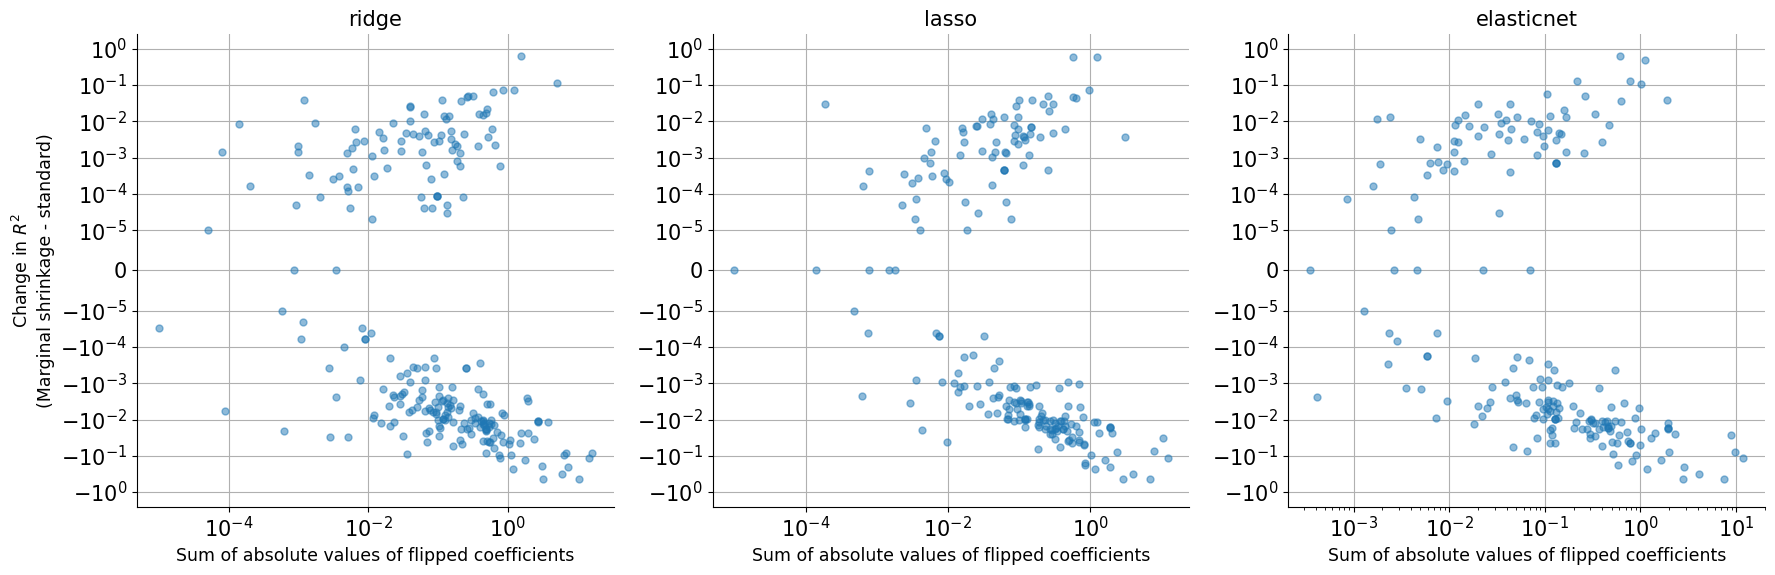

In [102]:
fig, axes = plt.subplots(1, len(models), figsize=(len(models) * 6, 6))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, model in enumerate(models):
    dd = df["d_sign"][i]
    dd = dd[~dd.sum_abs_flipped_values_baseline.isna()]
    dd = (
        dd.groupby(by=["dataset_name"])[
            ["r2_shrinkage-baseline", "sum_abs_flipped_values_baseline"]
        ]
        .mean()
        .reset_index()
    ).round(5)
    # dd['yplot'] = np.log(np.abs(dd['r2_shrinkage-baseline'])) * np.sign(dd['r2_shrinkage-baseline'])
    # sns.scatterplot(data=dd, x='sum_abs_flipped_values_baseline', y='r2_shrinkage-baseline')
    ax = axes[i]
    ax.grid(zorder=-1000)
    ax.plot(
        dd["sum_abs_flipped_values_baseline"],
        dd["r2_shrinkage-baseline"],
        "o",
        ms=5,
        alpha=0.5,
    )
    ax.set_xscale("log")
    minval = np.abs(dd["r2_shrinkage-baseline"][dd["r2_shrinkage-baseline"] != 0]).min()
    ax.set_yscale("symlog", linthresh=minval)
    ax.set_xlabel("Sum of absolute values of flipped coefficients", fontsize="small")
    if i == 0:
        ax.set_ylabel(
            "Change in $R^2$\n(Marginal shrinkage - standard)", fontsize="small"
        )
    ax.set_title(model, fontsize="medium")
    ax.set_ylim(-2.5, 2.5)
plt.tight_layout()
plt.show()

In [ ]:
dd[['r2_shrinkage-baseline', 'sum_abs_flipped_values_baseline']].describe()

### Extra coef plots

In [100]:

dd.sort_values(by='r2_shrinkage-baseline', ascending=False).head(10)

,dataset_name,r2_shrinkage-baseline,sum_abs_flipped_values_baseline
35,527_analcatdata_election2000,0.614183,0.611357
5,1096_FacultySalaries,0.492037,1.124067
221,kddcup,0.131890,0.771440
145,analcatdata_fraud,0.126053,0.219737
142,analcatdata_cyyoung8092,0.104337,1.024987
151,appendicitis,0.056717,0.105787
18,210_cloud,0.049640,0.266353
154,backache,0.042510,0.000000
205,glass2,0.037707,1.908857
148,analcatdata_japansolvent,0.035990,0.629610


In [ ]:
fig, axes = plt.subplots(1, len(models), figsize=(len(models) * 6, 6))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, model in enumerate(models):
    d_sign = df['d_sign'][i]
    ax = axes[i]
    sns.barplot(y='dataset_name', x='sign_flip_frac_baseline', data=d_sign, ax=ax)
    ax.set_xlabel('Frac signs flipped')
    if i > 0:
        ax.set_ylabel('')
        # hide y ticks
        ax.set_yticks([])
    ax.set_title(model, fontsize='medium')
    ax.grid(axis='x')
    plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 6))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, model in enumerate(models):
    d_sign = df['d_sign'][i].explode(column='flipped_values_baseline')
    ax = axes[i]
    d_sign_filt = d_sign[~d_sign.flipped_values_baseline.isna()]
    sns.stripplot(y='dataset_name', x='flipped_values_baseline', data=d_sign_filt, ax=ax, hue='dataset_name', legend=False)
    ax.set_xlabel('Flipped coef values (main)')
    if i > 0:
        ax.set_ylabel('')
        # hide y ticks
        ax.set_yticks([])
    ax.set_title(model, fontsize='medium')
    ax.grid(axis='x')
    plt.tight_layout()
plt.show()